In [2]:
# Imports and configuration
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')

ROOT = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
DATA_PATH = os.path.join(ROOT, 'dataset', 'initial_data.csv')
PLOTS_DIR = os.path.join(ROOT, 'plots')
os.makedirs(PLOTS_DIR, exist_ok=True)

print('DATA_PATH =', DATA_PATH)
print('PLOTS_DIR =', PLOTS_DIR)

DATA_PATH = /home/pusparegmi/Programming/Projects/NepalTourismPrediction/dataset/initial_data.csv
PLOTS_DIR = /home/pusparegmi/Programming/Projects/NepalTourismPrediction/plots


Data shape: (360, 3)
            Year Month  Value
date                         
1995-01-01  1995   Jan  22207
1995-02-01  1995   Feb  28240
1995-03-01  1995   Mar  34219
1995-04-01  1995   Apr  33994
1995-05-01  1995   May  27843


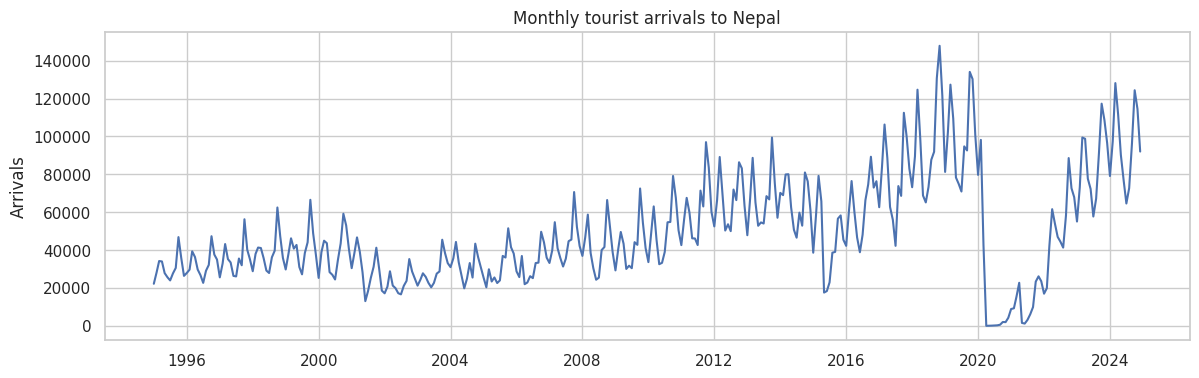

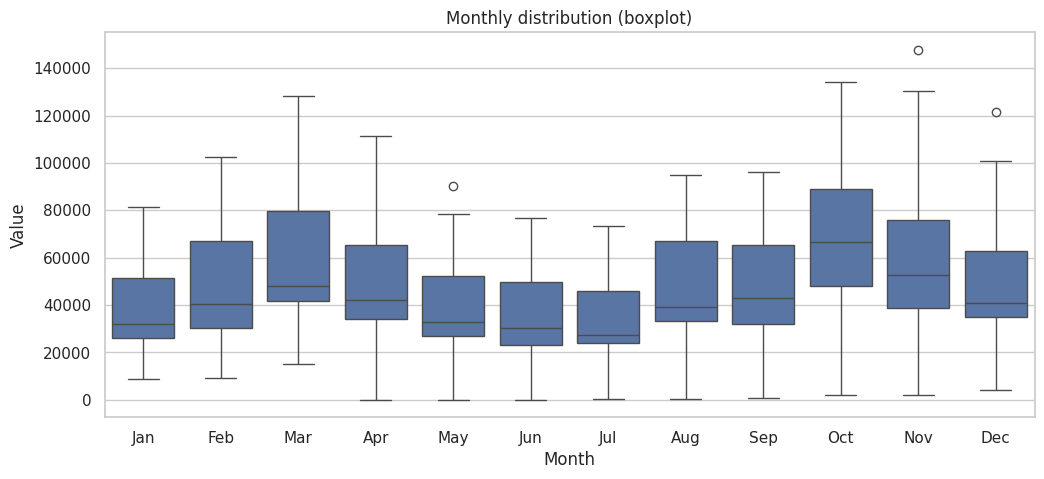

In [3]:
# Data loading and basic EDA

def load_series(path=DATA_PATH):
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'], format='%Y-%b')
    df = df.set_index('date').sort_index()
    ts = df['Value'].astype(float)
    ts.name = 'tourists'
    return df, ts

raw_df, ts = load_series()
print('Data shape:', raw_df.shape)
print(raw_df.head())

plt.figure(figsize=(14,4))
plt.plot(ts)
plt.title('Monthly tourist arrivals to Nepal')
plt.ylabel('Arrivals')
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x=raw_df['Month'], y=raw_df['Value'], order=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.title('Monthly distribution (boxplot)')
plt.show()

ADF Statistic: -3.8360
p-value: 0.0026
Critial Values: 1% -3.4494474563375737
Critial Values: 5% -2.8699542285903887
Critial Values: 10% -2.5712527305187987


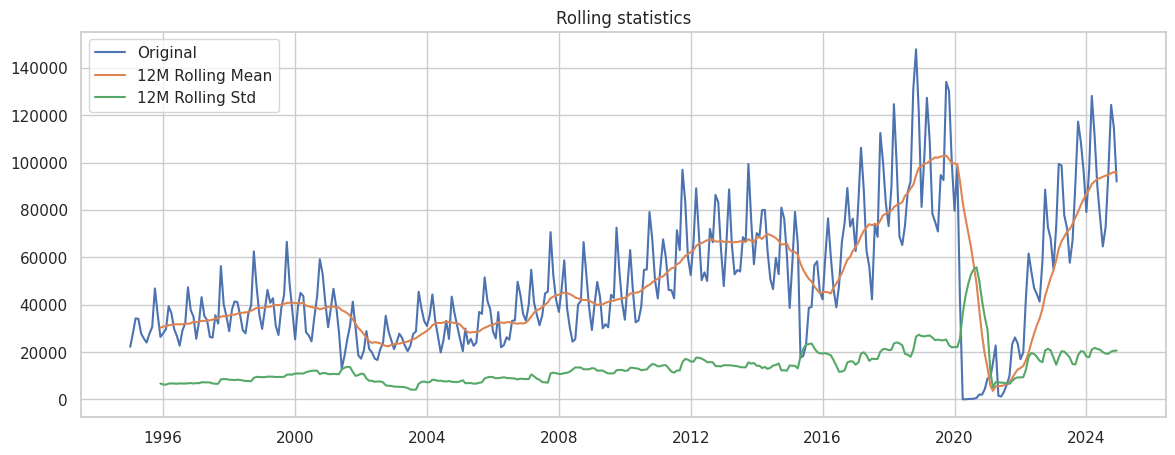

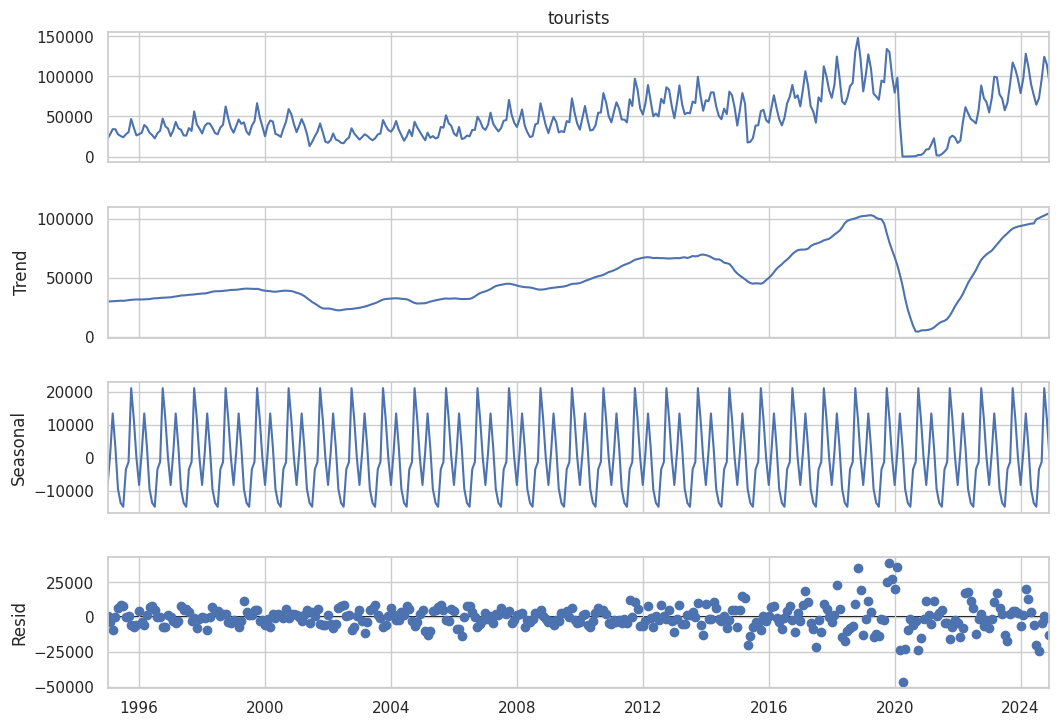

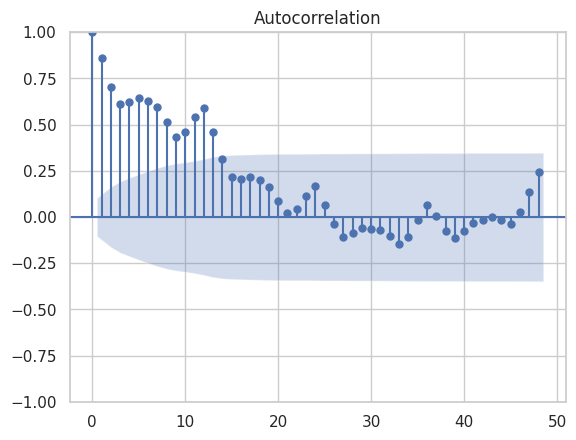

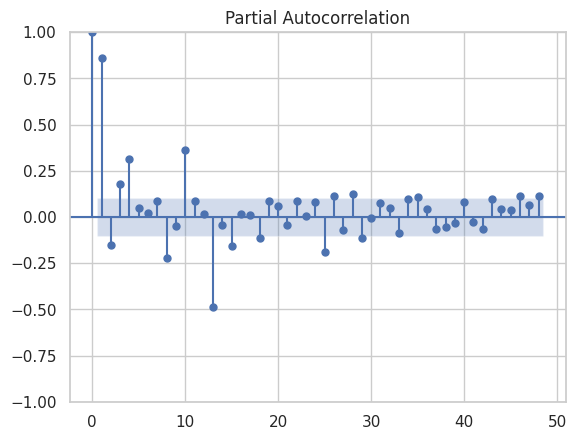

In [4]:
# Stationarity check: ADF test and rolling stats

def adf_test(series):
    res = adfuller(series.dropna())
    print(f'ADF Statistic: {res[0]:.4f}')
    print(f'p-value: {res[1]:.4f}')
    for k, v in res[4].items():
        print('Critial Values:', k, v)

adf_test(ts)

plt.figure(figsize=(14,5))
plt.plot(ts, label='Original')
plt.plot(ts.rolling(12).mean(), label='12M Rolling Mean')
plt.plot(ts.rolling(12).std(), label='12M Rolling Std')
plt.legend()
plt.title('Rolling statistics')
plt.show()

# Seasonal decomposition
res = seasonal_decompose(ts, model='additive', period=12, extrapolate_trend='freq')
fig = res.plot()
fig.set_size_inches(12,8)
plt.show()

# ACF/PACF
plot_acf(ts.dropna(), lags=48)
plt.show()
plot_pacf(ts.dropna(), lags=48, method='ywm')
plt.show()

Best ARIMA order: (2, 1, 2) AIC: 7526.834254288076
                               SARIMAX Results                                
Dep. Variable:               tourists   No. Observations:                  348
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3758.417
Date:                Sun, 08 Feb 2026   AIC                           7526.834
Time:                        14:23:46   BIC                           7546.081
Sample:                    01-01-1995   HQIC                          7534.498
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0017      0.009    115.450      0.000       0.985       1.019
ar.L2         -0.9937      0.009   -110.648      0.000      -1.011      -0.976
m

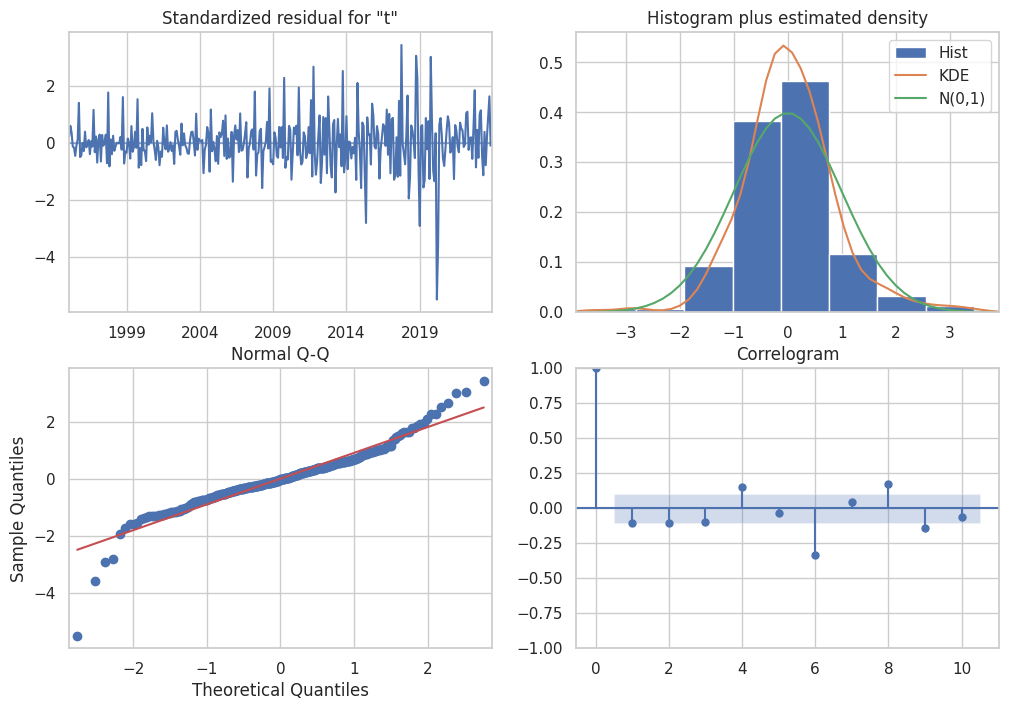

Best SARIMA config: ((0, 1, 2), (1, 1, 1, 12)) AIC: 6799.190693354849
                                      SARIMAX Results                                       
Dep. Variable:                             tourists   No. Observations:                  348
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -3394.595
Date:                              Sun, 08 Feb 2026   AIC                           6799.191
Time:                                      14:24:21   BIC                           6818.032
Sample:                                  01-01-1995   HQIC                          6806.715
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0630      0

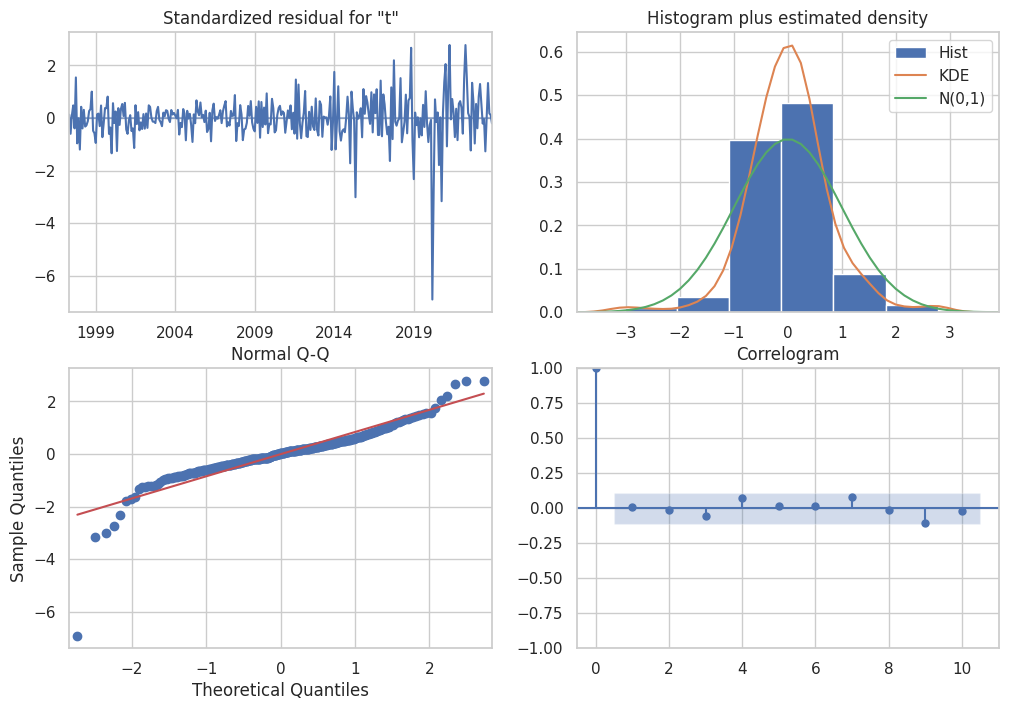

In [5]:
# Split train/test (last 12 months test)
train = ts.iloc[:-12]
test = ts.iloc[-12:]

# Simple ARIMA grid search
best_aic = np.inf
best_order = None
best_res = None
for p in range(3):
    for d in range(2):
        for q in range(3):
            try:
                model = ARIMA(train, order=(p,d,q))
                res = model.fit()
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = (p,d,q)
                    best_res = res
            except Exception:
                continue

print('Best ARIMA order:', best_order, 'AIC:', best_aic)
print(best_res.summary())

# Diagnostics
best_res.plot_diagnostics(figsize=(12,8))
plt.show()

# Fit best SARIMA (simple search)
best_aic_s = np.inf
best_cfg_s = None
best_res_s = None
for p in range(3):
    for d in range(2):
        for q in range(3):
            for P in range(2):
                for D in range(2):
                    for Q in range(2):
                        try:
                            model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,12), enforce_stationarity=False, enforce_invertibility=False)
                            res = model.fit(disp=False)
                            if res.aic < best_aic_s:
                                best_aic_s = res.aic
                                best_cfg_s = ((p,d,q),(P,D,Q,12))
                                best_res_s = res
                        except Exception:
                            continue

print('Best SARIMA config:', best_cfg_s, 'AIC:', best_aic_s)
print(best_res_s.summary())

best_res_s.plot_diagnostics(figsize=(12,8))
plt.show()

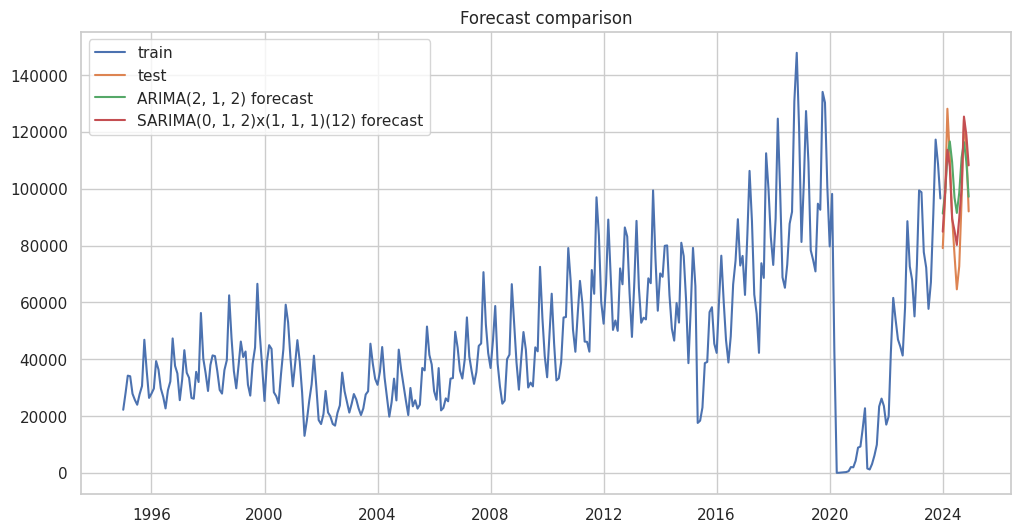

ARIMA eval: {'rmse': np.float64(15706.600987876043), 'mae': 13372.447790335864, 'mape': np.float64(15.911592230470237)}
SARIMA eval: {'rmse': np.float64(9852.877053323477), 'mae': 7758.75409920644, 'mape': np.float64(9.127423666095945)}


<Figure size 640x480 with 0 Axes>

In [6]:
# Forecast and evaluate
arima_pred = best_res.get_forecast(steps=12).predicted_mean
arima_pred.index = test.index
sarima_pred = best_res_s.get_forecast(steps=12).predicted_mean
sarima_pred.index = test.index

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(arima_pred.index, arima_pred, label=f'ARIMA{best_order} forecast')
plt.plot(sarima_pred.index, sarima_pred, label=f'SARIMA{best_cfg_s[0]}x{best_cfg_s[1][:3]}(12) forecast')
plt.legend()
plt.title('Forecast comparison')
plt.show()

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'rmse': rmse, 'mae': mae, 'mape': mape}

print('ARIMA eval:', metrics(test.values, arima_pred.values))
print('SARIMA eval:', metrics(test.values, sarima_pred.values))

# Save results
with open(os.path.join(PLOTS_DIR, 'arima_summary.txt'), 'w') as f:
    f.write(best_res.summary().as_text())
with open(os.path.join(PLOTS_DIR, 'sarima_summary.txt'), 'w') as f:
    f.write(best_res_s.summary().as_text())

plt.savefig(os.path.join(PLOTS_DIR, 'models_forecast_comparison.png'), bbox_inches='tight')

# Conclusion (markdown)


## Conclusion

- Both ARIMA and SARIMA were fitted using small grid searches with AIC selection.
- Diagnostic plots and summary files were saved to the `plots/` directory.
- Evaluation on the holdout (last 12 months) is reported; use these metrics to compare models and choose the best.

Recommendations for further work:
- Expand grid search or use auto_arima for better order selection.
- Incorporate exogenous regressors (e.g., economic indicators, global travel restrictions).
- Use time-series cross-validation and produce probabilistic forecasts (prediction intervals) for deployment.

## Model evaluation — forecasts, residuals, validation, and classification-style metrics

This section provides rigorous evaluation of the fitted ARIMA and SARIMA models:

- Plot actual vs predicted series including 95% prediction intervals.
- Residual diagnostics (histogram, ACF of residuals) to check model assumptions.
- Time-series cross-validation (rolling-origin) to assess out-of-sample error stability across folds.
- For demonstration, convert the forecasting task into a simple binary classification ("month-over-month increase") to compute accuracy and ROC/AUC. Note: ROC and accuracy are classification metrics and are shown here only for illustrative comparison after binarizing the outcome.

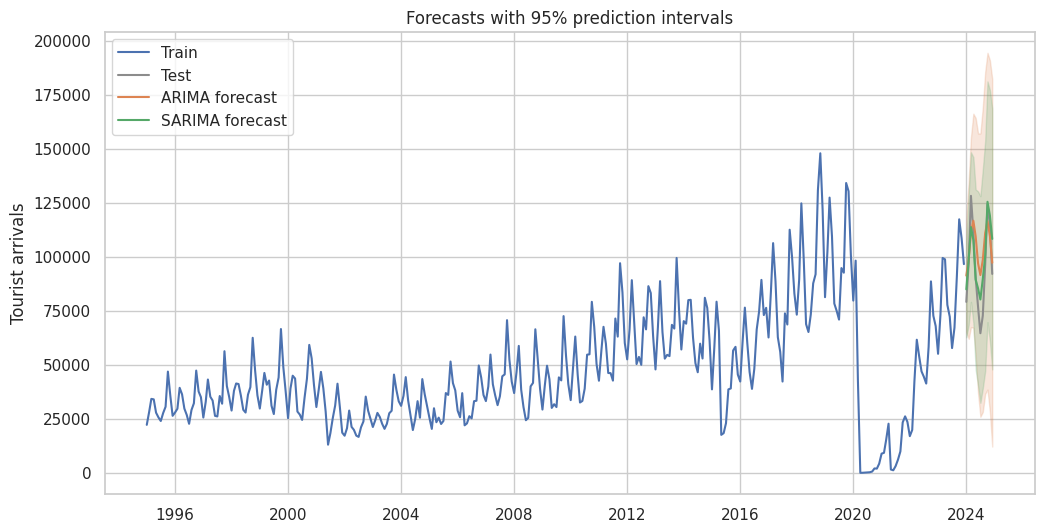

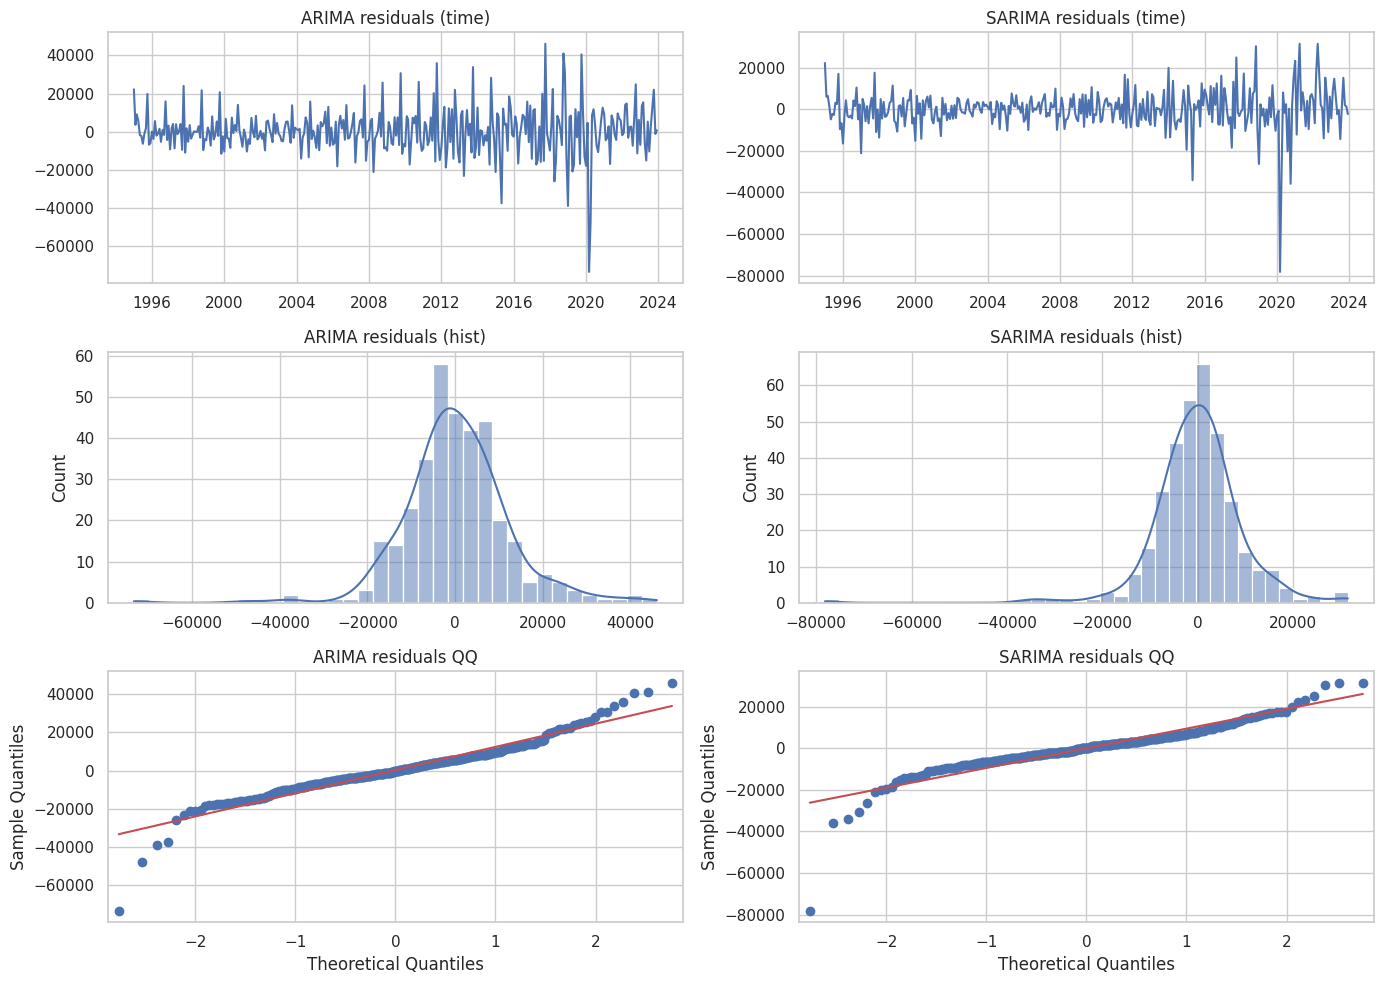

<Figure size 1200x400 with 0 Axes>

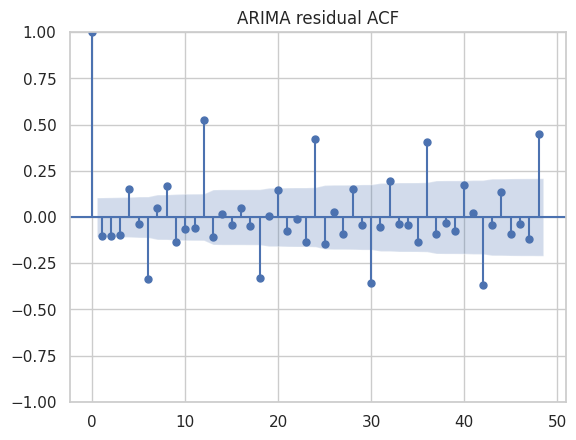

<Figure size 1200x400 with 0 Axes>

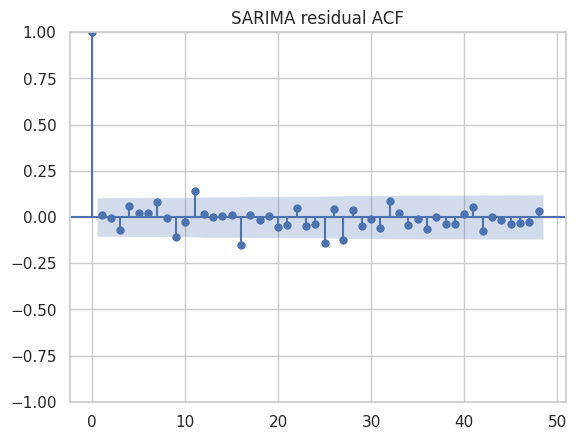

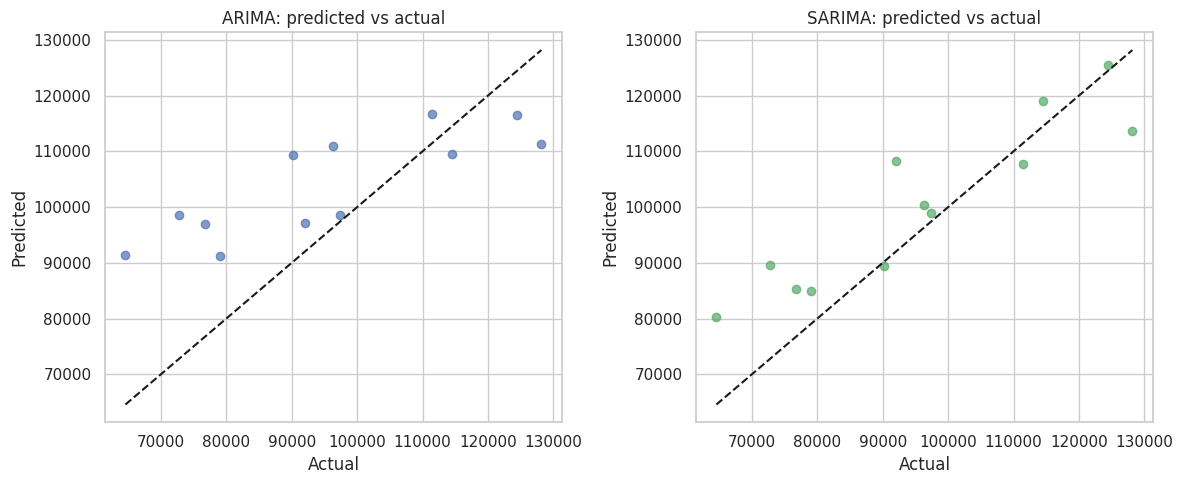

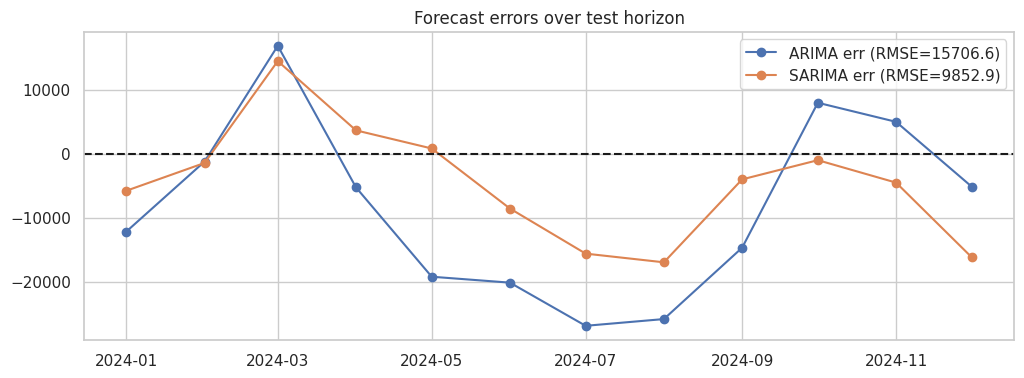

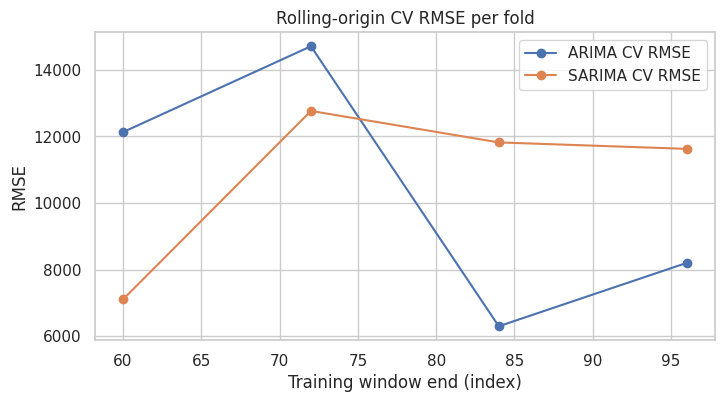

Test accuracy (month-over-month increase) — ARIMA: 0.8333333333333334  SARIMA: 0.9166666666666666


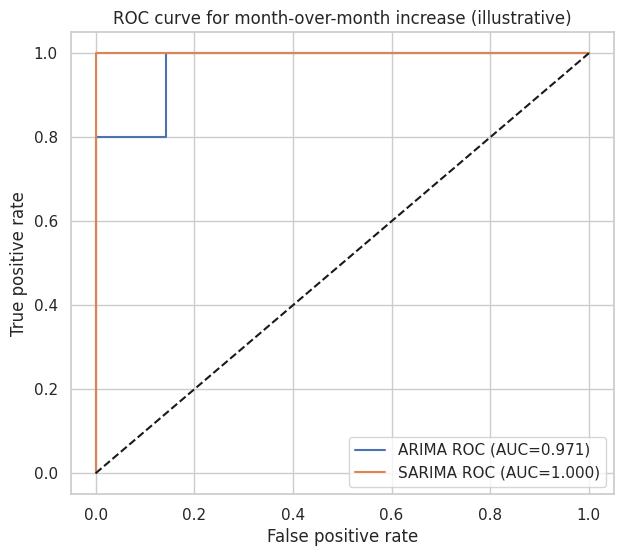

Saved plots and evaluation metrics to /home/pusparegmi/Programming/Projects/NepalTourismPrediction/plots


In [7]:
# Comprehensive evaluation: forecasts, residuals, CV, and classification-style metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score, roc_curve
from statsmodels.graphics.gofplots import qqplot

# Forecasts with confidence intervals (12-step test horizon)
arima_forecast = best_res.get_forecast(steps=len(test))
arima_mean = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int(alpha=0.05)
arima_mean.index = test.index
arima_ci.index = test.index

sarima_forecast = best_res_s.get_forecast(steps=len(test))
sarima_mean = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int(alpha=0.05)
sarima_mean.index = test.index
sarima_ci.index = test.index

# 1) Forecast plot with 95% CI
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train', color='C0')
plt.plot(test.index, test, label='Test', color='C7')
plt.plot(arima_mean.index, arima_mean, label='ARIMA forecast', color='C1')
plt.fill_between(arima_ci.index, arima_ci.iloc[:,0], arima_ci.iloc[:,1], color='C1', alpha=0.2)
plt.plot(sarima_mean.index, sarima_mean, label='SARIMA forecast', color='C2')
plt.fill_between(sarima_ci.index, sarima_ci.iloc[:,0], sarima_ci.iloc[:,1], color='C2', alpha=0.2)
plt.legend()
plt.title('Forecasts with 95% prediction intervals')
plt.ylabel('Tourist arrivals')
plt.savefig(os.path.join(PLOTS_DIR, 'forecast_with_ci.png'), bbox_inches='tight')
plt.show()

# 2) Residual diagnostics (time plot, histogram, QQ, ACF)
arima_resid = best_res.resid.dropna()
sarima_resid = best_res_s.resid.dropna()

plt.figure(figsize=(14,10))
plt.subplot(3,2,1)
plt.plot(arima_resid)
plt.title('ARIMA residuals (time)')
plt.subplot(3,2,2)
plt.plot(sarima_resid)
plt.title('SARIMA residuals (time)')

plt.subplot(3,2,3)
sns.histplot(arima_resid, kde=True)
plt.title('ARIMA residuals (hist)')
plt.subplot(3,2,4)
sns.histplot(sarima_resid, kde=True)
plt.title('SARIMA residuals (hist)')

plt.subplot(3,2,5)
qqplot(arima_resid, line='s', ax=plt.gca())
plt.title('ARIMA residuals QQ')
plt.subplot(3,2,6)
qqplot(sarima_resid, line='s', ax=plt.gca())
plt.title('SARIMA residuals QQ')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'residual_diagnostics.png'), bbox_inches='tight')
plt.show()

# ACF of residuals
plt.figure(figsize=(12,4))
plot_acf(arima_resid, lags=48)
plt.title('ARIMA residual ACF')
plt.savefig(os.path.join(PLOTS_DIR, 'arima_resid_acf.png'), bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,4))
plot_acf(sarima_resid, lags=48)
plt.title('SARIMA residual ACF')
plt.savefig(os.path.join(PLOTS_DIR, 'sarima_resid_acf.png'), bbox_inches='tight')
plt.show()

# 3) Predicted vs actual scatter and error over time
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(test.values, arima_mean.values, label='ARIMA', alpha=0.7)
plt.plot([test.min(), test.max()], [test.min(), test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('ARIMA: predicted vs actual')

plt.subplot(1,2,2)
plt.scatter(test.values, sarima_mean.values, label='SARIMA', alpha=0.7, color='C2')
plt.plot([test.min(), test.max()], [test.min(), test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('SARIMA: predicted vs actual')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'pred_vs_actual_scatter.png'), bbox_inches='tight')
plt.show()

# Errors over time
arima_err = test.values - arima_mean.values
sarima_err = test.values - sarima_mean.values

plt.figure(figsize=(12,4))
plt.plot(test.index, arima_err, marker='o', label=f'ARIMA err (RMSE={np.sqrt(mean_squared_error(test, arima_mean)):.1f})')
plt.plot(test.index, sarima_err, marker='o', label=f'SARIMA err (RMSE={np.sqrt(mean_squared_error(test, sarima_mean)):.1f})')
plt.axhline(0, color='k', linestyle='--')
plt.legend()
plt.title('Forecast errors over test horizon')
plt.savefig(os.path.join(PLOTS_DIR, 'errors_over_time.png'), bbox_inches='tight')
plt.show()

# 4) Rolling-origin cross-validation: compute RMSE per fold and plot
def rolling_forecast_cv_rmse(series, model_builder, initial_train=60, h=12, n_splits=4):
    rmses = []
    indices = []
    n = len(series)
    for i in range(n_splits):
        train_end = initial_train + i*h
        if train_end + h > n:
            break
        train_cv = series.iloc[:train_end]
        test_cv = series.iloc[train_end:train_end+h]
        model = model_builder(train_cv)
        pred = model.get_forecast(steps=h).predicted_mean
        rmses.append(np.sqrt(mean_squared_error(test_cv.values, pred.values)))
        indices.append(train_end)
    return indices, rmses

arima_builder = lambda tr: ARIMA(tr, order=best_order).fit()
sarima_builder = lambda tr: SARIMAX(tr, order=best_cfg_s[0], seasonal_order=(best_cfg_s[1][0], best_cfg_s[1][1], best_cfg_s[1][2], 12), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

idx_a, rmses_a = rolling_forecast_cv_rmse(ts, arima_builder, initial_train=60, h=12, n_splits=4)
idx_s, rmses_s = rolling_forecast_cv_rmse(ts, sarima_builder, initial_train=60, h=12, n_splits=4)

plt.figure(figsize=(8,4))
plt.plot(idx_a, rmses_a, marker='o', label='ARIMA CV RMSE')
plt.plot(idx_s, rmses_s, marker='o', label='SARIMA CV RMSE')
plt.xlabel('Training window end (index)')
plt.ylabel('RMSE')
plt.title('Rolling-origin CV RMSE per fold')
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR, 'cv_rmse_per_fold.png'), bbox_inches='tight')
plt.show()

# 5) Classification-style evaluation (month-over-month increase) - illustrative
# define previous-month baseline for test: previous actual for first test point is last train point
prev = np.concatenate([train.values[-1:], test.values[:-1]])
labels = (test.values > prev).astype(int)

# ARIMA predicted class/score
arima_score = (arima_mean.values - prev)  # positive means increase predicted
arima_class = (arima_mean.values > prev).astype(int)
# SARIMA
sarima_score = (sarima_mean.values - prev)
sarima_class = (sarima_mean.values > prev).astype(int)

# Accuracy
acc_a = accuracy_score(labels, arima_class)
acc_s = accuracy_score(labels, sarima_class)

print('Test accuracy (month-over-month increase) — ARIMA:', acc_a, ' SARIMA:', acc_s)

# ROC/AUC (only if both classes present)
if len(np.unique(labels)) == 2:
    auc_a = roc_auc_score(labels, arima_score)
    auc_s = roc_auc_score(labels, sarima_score)
    fpr_a, tpr_a, _ = roc_curve(labels, arima_score)
    fpr_s, tpr_s, _ = roc_curve(labels, sarima_score)
    plt.figure(figsize=(7,6))
    plt.plot(fpr_a, tpr_a, label=f'ARIMA ROC (AUC={auc_a:.3f})')
    plt.plot(fpr_s, tpr_s, label=f'SARIMA ROC (AUC={auc_s:.3f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for month-over-month increase (illustrative)')
    plt.legend()
    plt.savefig(os.path.join(PLOTS_DIR, 'roc_month_over_month.png'), bbox_inches='tight')
    plt.show()
else:
    print('Labels for month-over-month increase are constant; ROC/AUC not computed.')

# Save numeric evaluation to text
with open(os.path.join(PLOTS_DIR, 'evaluation_metrics.txt'), 'w') as f:
    f.write('ARIMA RMSE: %.3f\n' % np.sqrt(mean_squared_error(test, arima_mean)))
    f.write('SARIMA RMSE: %.3f\n' % np.sqrt(mean_squared_error(test, sarima_mean)))
    f.write('ARIMA MAE: %.3f\n' % mean_absolute_error(test, arima_mean))
    f.write('SARIMA MAE: %.3f\n' % mean_absolute_error(test, sarima_mean))
    f.write('ARIMA accuracy (m-o-m): %s\n' % acc_a)
    f.write('SARIMA accuracy (m-o-m): %s\n' % acc_s)

print('Saved plots and evaluation metrics to', PLOTS_DIR)